<div style="font-size:2.5em; font-weight:bold; text-align:center; margin-top:20px;">CNN-Based MNIST Digit Recognition</div>



<div style="text-align:center; margin-bottom:30px;">A comprehensive project for digit recognition using Convolutional Neural Networks</div>

# 1. Introduction

This notebook demonstrates the implementation of a Convolutional Neural Network (CNN) for handwritten digit recognition using the MNIST dataset. The MNIST dataset consists of 70,000 grayscale images of handwritten digits (0-9), each 28×28 pixels in size.

We'll go through the entire process from data preparation to model evaluation, including:
- Loading and preprocessing the MNIST dataset
- Building a CNN architecture
- Training the model
- Evaluating model performance
- Visualizing results and feature maps

# 2. Setup

Let's start by importing the necessary libraries and setting up our environment.

In [1]:
# Import standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Check if GPU is available
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Create directories for outputs if they don't exist
os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

2025-04-16 02:25:04.643303: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 02:25:04.684229: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 02:25:04.685929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 02:25:05.612131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0
Num GPUs Available:  0


# 3. Data Preparation

In this section, we'll load the MNIST dataset and prepare it for training our CNN model.

We need to perform the following data preparation steps:
1. Load the MNIST dataset
2. Normalize pixel values to the range [0, 1]
3. Reshape the data to include a channel dimension (28x28x1)
4. Convert labels to one-hot encoded vectors
5. Split the data into training, validation, and test sets

In [2]:
def load_and_preprocess_data(val_split=0.1, random_seed=42):
    # Load MNIST data from keras
    print("Loading MNIST dataset...")
    (x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
    
    # Normalize pixel values to [0, 1]
    x_train_full = x_train_full.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Reshape to include channel dimension (28x28x1)
    x_train_full = x_train_full.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    
    # Convert class vectors to binary class matrices (one-hot encoding)
    y_train_full = to_categorical(y_train_full, 10)
    y_test = to_categorical(y_test, 10)
    
    # Split training data into train and validation sets
    np.random.seed(random_seed)
    indices = np.random.permutation(len(x_train_full))
    val_size = int(len(x_train_full) * val_split)
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]
    
    x_val = x_train_full[val_indices]
    y_val = y_train_full[val_indices]
    x_train = x_train_full[train_indices]
    y_train = y_train_full[train_indices]
    
    print(f"Training set: {x_train.shape[0]} samples")
    print(f"Validation set: {x_val.shape[0]} samples")
    print(f"Test set: {x_test.shape[0]} samples")
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Load and preprocess data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_preprocess_data()

Loading MNIST dataset...
11490434/11490434 [==============================] - 0s 0us/step
Training set: 54000 samples
Validation set: 6000 samples
Test set: 10000 samples


## 3.1. Data Visualization

Let's visualize some examples from the MNIST dataset to get a better understanding of the data.

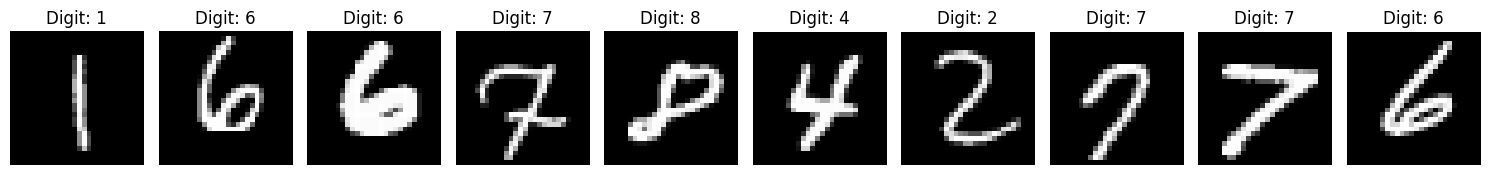

In [3]:
def visualize_mnist_samples(x_data, y_data, num_samples=10):
    """Visualize sample images from the MNIST dataset."""
    plt.figure(figsize=(15, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        
        # Get the image and reshape it to 28x28
        img = x_data[i].reshape(28, 28)
        
        # Get the label (assuming one-hot encoded)
        label = np.argmax(y_data[i])
        
        plt.imshow(img, cmap='gray')
        plt.title(f"Digit: {label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('figures/mnist_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize MNIST samples
visualize_mnist_samples(x_train, y_train)

## 3.2. Data Augmentation

Data augmentation is a technique to artificially increase the size of the training dataset by applying various transformations to the original images. This helps improve model generalization and reduces overfitting.

Let's define a data augmentation pipeline for our MNIST images:

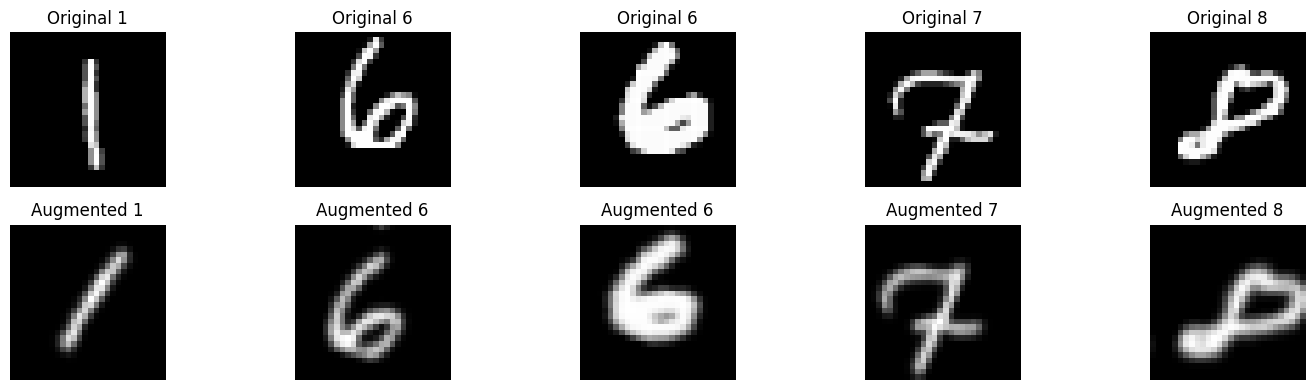

In [4]:
def create_data_augmentation():
    """Create a data augmentation pipeline for MNIST dataset."""
    data_augmentation = models.Sequential([
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
    ])
    return data_augmentation

# Create data augmentation pipeline
data_augmentation = create_data_augmentation()

# Visualize augmented samples
plt.figure(figsize=(15, 4))
for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    img = x_train[i].reshape(28, 28, 1)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Original {np.argmax(y_train[i])}")
    plt.axis('off')
    
    ax = plt.subplot(2, 5, i+6)
    augmented_img = data_augmentation(tf.expand_dims(img, 0))[0]
    plt.imshow(augmented_img.numpy().reshape(28, 28), cmap='gray')
    plt.title(f"Augmented {np.argmax(y_train[i])}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('figures/augmented_samples.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. CNN Architecture

Convolutional Neural Networks (CNNs) are particularly well-suited for image classification tasks. They use convolutional layers to automatically detect features in images, followed by pooling layers to reduce dimensionality while preserving important information.

For our MNIST model, we'll implement a simple CNN architecture with the following components:
- Convolutional layers with ReLU activation
- Max pooling layers
- Dropout for regularization
- Batch normalization for faster convergence
- Dense layers for classification

In [5]:
def create_simple_cnn():
    """Create a simple CNN model for MNIST classification."""
    model = models.Sequential([
        # Input layer (28x28x1)
        layers.Input(shape=(28, 28, 1)),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    return model

# Create the CNN model
model = create_simple_cnn()

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)       

## 4.1. Model Compilation

Now that we have defined our model architecture, we need to compile it with an appropriate loss function, optimizer, and evaluation metrics.

In [6]:
def compile_model(model):
    """Compile the model with appropriate loss, optimizer, and metrics."""
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Compile the model
model = compile_model(model)

# 5. Model Training

Let's define callbacks to monitor and improve the training process:
- ModelCheckpoint: Save the best model based on validation accuracy
- EarlyStopping: Stop training if validation loss doesn't improve
- ReduceLROnPlateau: Reduce learning rate when metrics plateau

In [7]:
def create_callbacks():
    """Create callbacks for model training."""
    checkpoint_path = "models/mnist_cnn_best.h5"
    
    callbacks_list = [
        # Save the best model
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            restore_best_weights=True
        ),
        
        # Reduce learning rate
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    return callbacks_list

# Create callbacks
callbacks = create_callbacks()

## 5.1. Training Process

Now that we have our data, model, and callbacks ready, let's train the CNN model.

In [8]:
def train_model(model, x_train, y_train, x_val, y_val, callbacks, batch_size=128, epochs=20):
    """Train the model and return history."""
    print("Starting model training...")
    
    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Save the final model
    model.save("models/mnist_cnn_final.h5")
    print("Model training completed.")
    
    return history

# Train the model
history = train_model(model, x_train, y_train, x_val, y_val, callbacks)

Starting model training...
Epoch 1/20
422/422 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9302
Epoch 1: val_accuracy improved from -inf to 0.65117, saving model to models/mnist_cnn_best.h5
422/422 [==============================] - 74s 171ms/step - loss: 0.2294 - accuracy: 0.9302 - val_loss: 0.8734 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 2/20
422/422 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9774
Epoch 2: val_accuracy improved from 0.65117 to 0.98967, saving model to models/mnist_cnn_best.h5
422/422 [==============================] - 70s 165ms/step - loss: 0.0747 - accuracy: 0.9774 - val_loss: 0.0372 - val_accuracy: 0.9897 - lr: 0.0010
Epoch 3/20
422/422 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9838
Epoch 3: val_accuracy did not improve from 0.98967
422/422 [==============================] - 71s 169ms/step - loss: 0.0545 - accuracy: 0.9838 - val_loss: 0.0463 - val_accuracy: 0.9868 - lr: 0.0010
Ep

## 5.2. Training Visualization

Let's visualize the training process by plotting accuracy and loss curves.

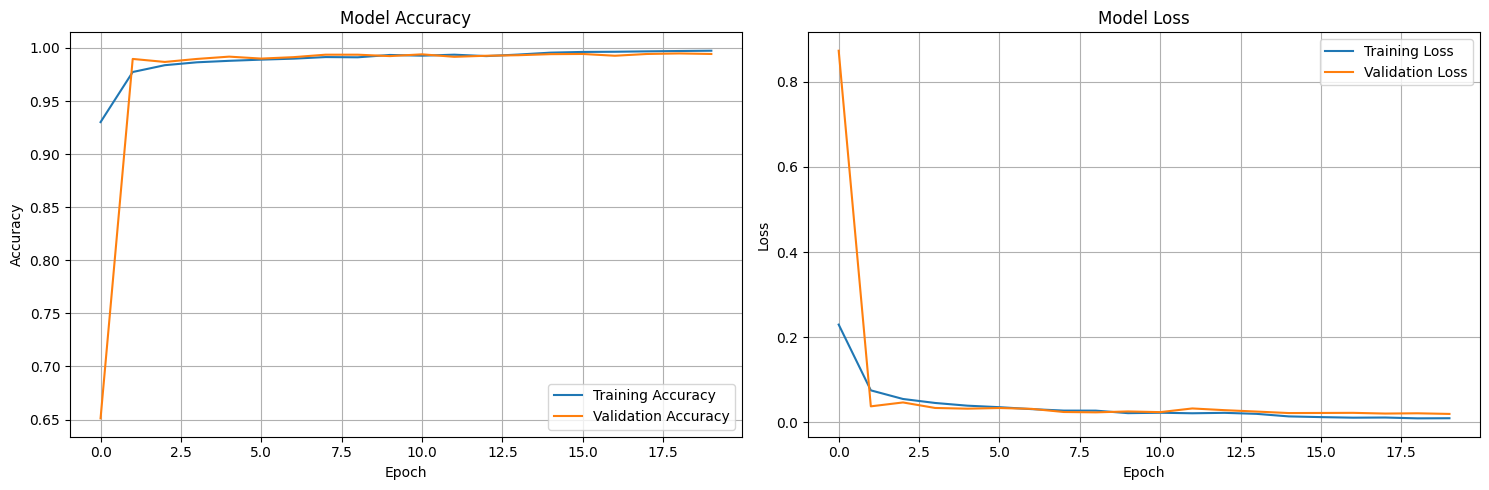

In [14]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss."""
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('figures/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training history
plot_training_history(history)

# 6. Model Evaluation

Let's evaluate the model on the test dataset to see how well it generalizes to unseen data.

def evaluate_model(model, x_test, y_test):
    """Evaluate the model on test data and return metrics."""
    print("Evaluating model on test data...")
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return test_loss, test_accuracy

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, x_test, y_test)

## 6.1. Confusion Matrix

A confusion matrix is a useful tool to visualize the performance of a classification model. It shows the counts of true positives, false positives, true negatives, and false negatives.

313/313 [==============================] - 3s 11ms/step


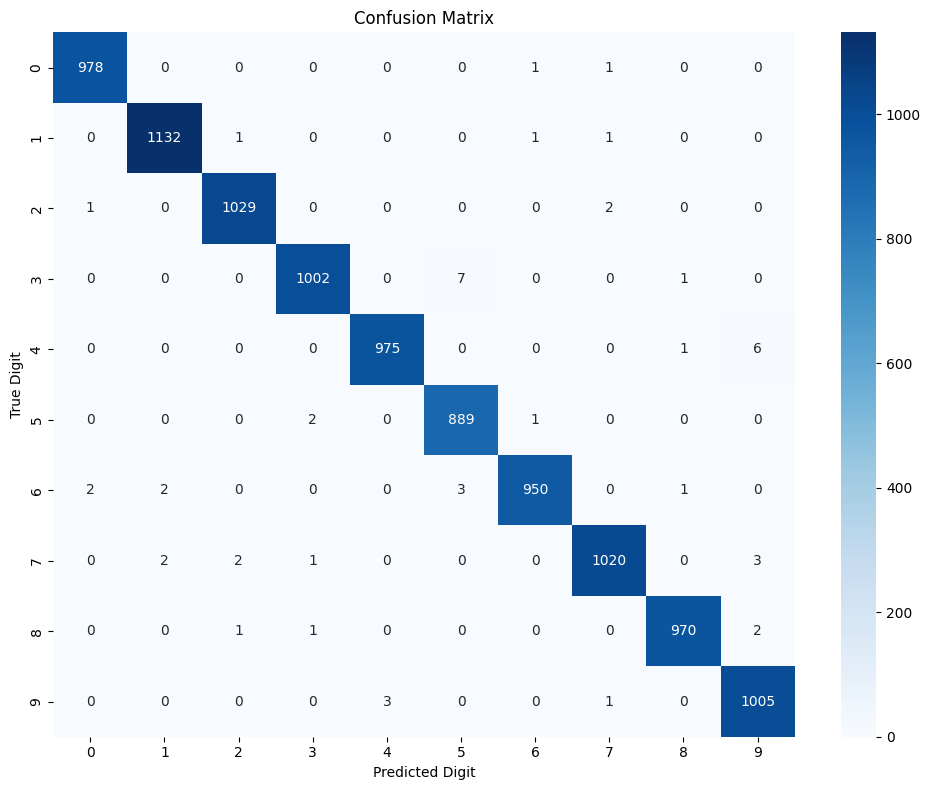


Classification Report:
              precision    recall  f1-score   support

           0     0.9969    0.9980    0.9975       980
           1     0.9965    0.9974    0.9969      1135
           2     0.9961    0.9971    0.9966      1032
           3     0.9960    0.9921    0.9940      1010
           4     0.9969    0.9929    0.9949       982
           5     0.9889    0.9966    0.9927       892
           6     0.9969    0.9916    0.9942       958
           7     0.9951    0.9922    0.9937      1028
           8     0.9969    0.9959    0.9964       974
           9     0.9892    0.9960    0.9926      1009

    accuracy                         0.9950     10000
   macro avg     0.9949    0.9950    0.9950     10000
weighted avg     0.9950    0.9950    0.9950     10000



In [15]:
def plot_confusion_matrix(model, x_test, y_test):
    """Plot confusion matrix for model evaluation."""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Get predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.ylabel('True Digit')
    plt.xlabel('Predicted Digit')
    plt.tight_layout()
    plt.savefig('figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate and print the classification report
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, digits=4))

# Plot confusion matrix
plot_confusion_matrix(model, x_test, y_test)

## 6.2. Visualizing Predictions

Let's visualize some of the model's predictions on test images to get a better understanding of how it performs.

1/1 [==============================] - 0s 28ms/step


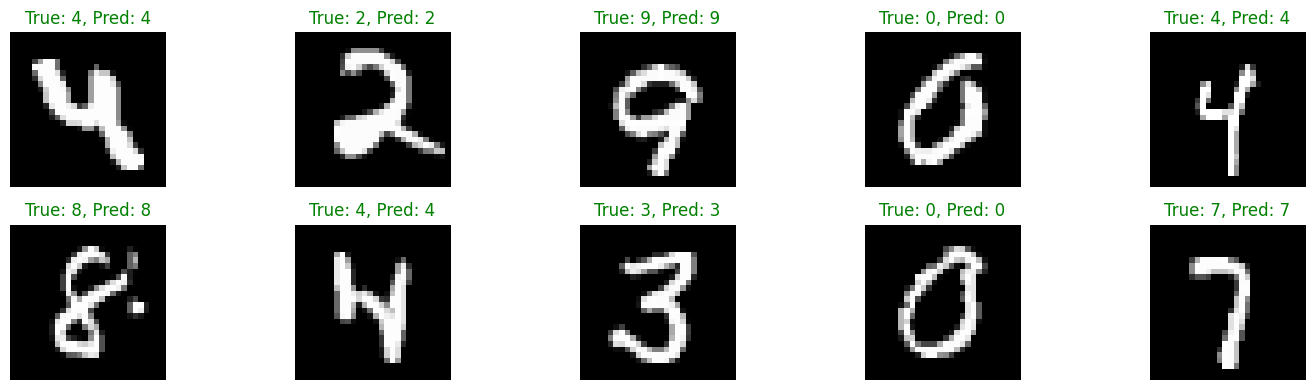

In [16]:
def visualize_predictions(model, x_test, y_test, num_samples=10):
    """Visualize model predictions on test samples."""
    # Get random sample indices
    indices = np.random.choice(range(len(x_test)), size=num_samples, replace=False)
    
    # Get predictions
    predictions = model.predict(x_test[indices])
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test[indices], axis=1)
    
    # Create a figure
    plt.figure(figsize=(15, 4))
    
    # Plot each sample
    for i, idx in enumerate(range(num_samples)):
        plt.subplot(2, 5, i+1)
        
        # Get the image and reshape it
        img = x_test[indices[idx]].reshape(28, 28)
        
        # Get prediction and true label
        pred = pred_classes[idx]
        true = true_classes[idx]
        
        # Set title color based on prediction correctness
        title_color = 'green' if pred == true else 'red'
        
        # Display the image
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true}, Pred: {pred}", color=title_color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('figures/prediction_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize predictions
visualize_predictions(model, x_test, y_test)

# 7. Feature Map Visualization

Feature maps show the activations of different convolutional filters when an image is passed through the network. They can provide insights into what features or patterns each filter is detecting.

1/1 [==============================] - 0s 77ms/step


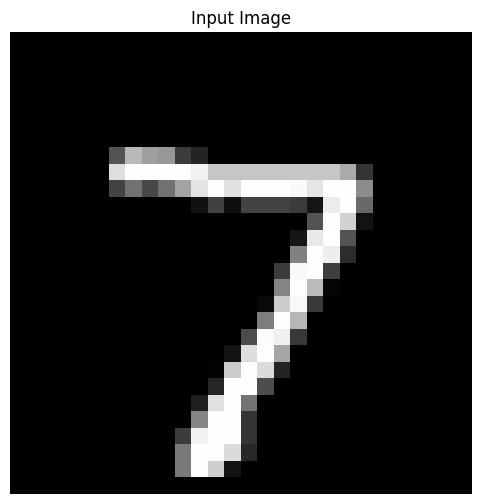

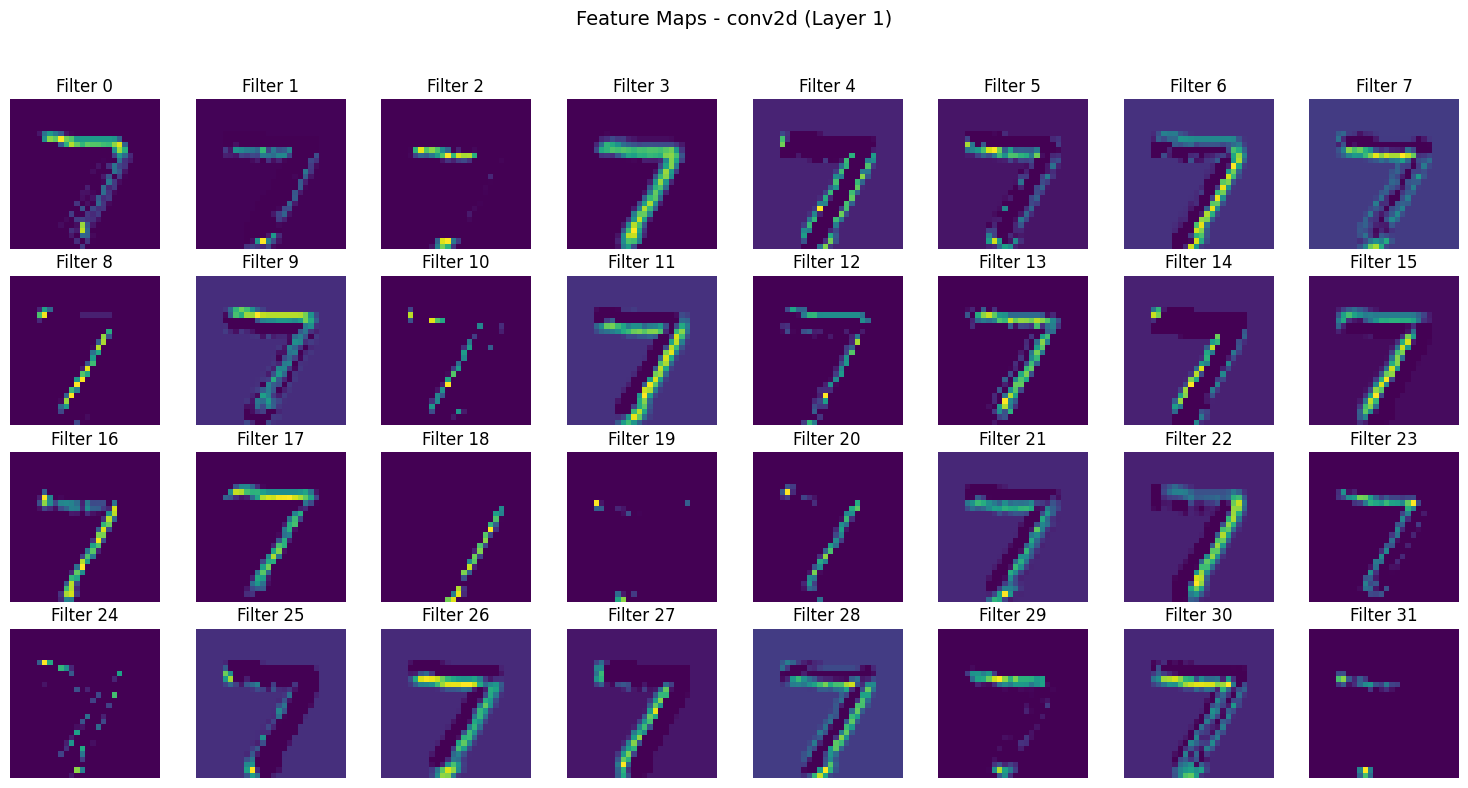

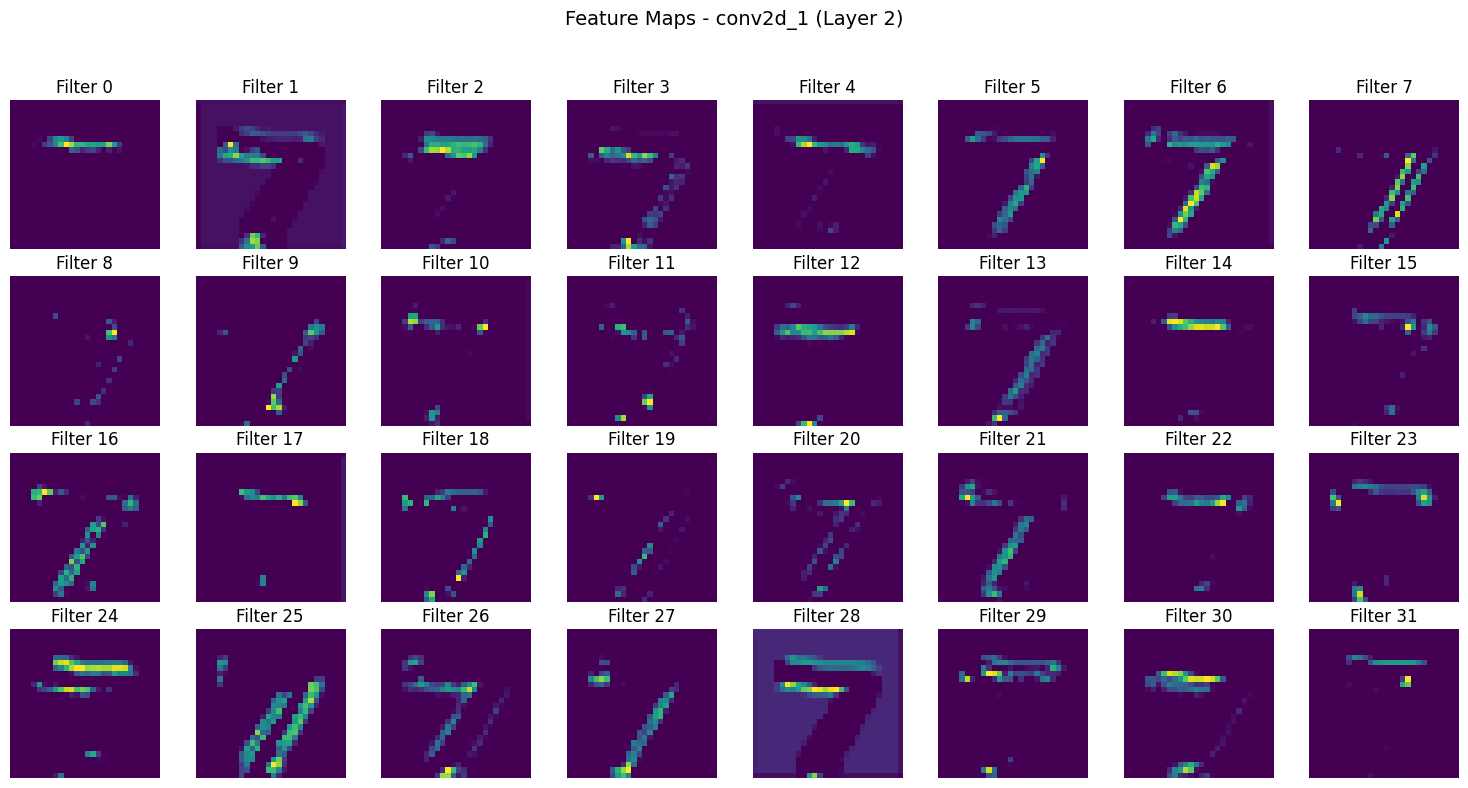

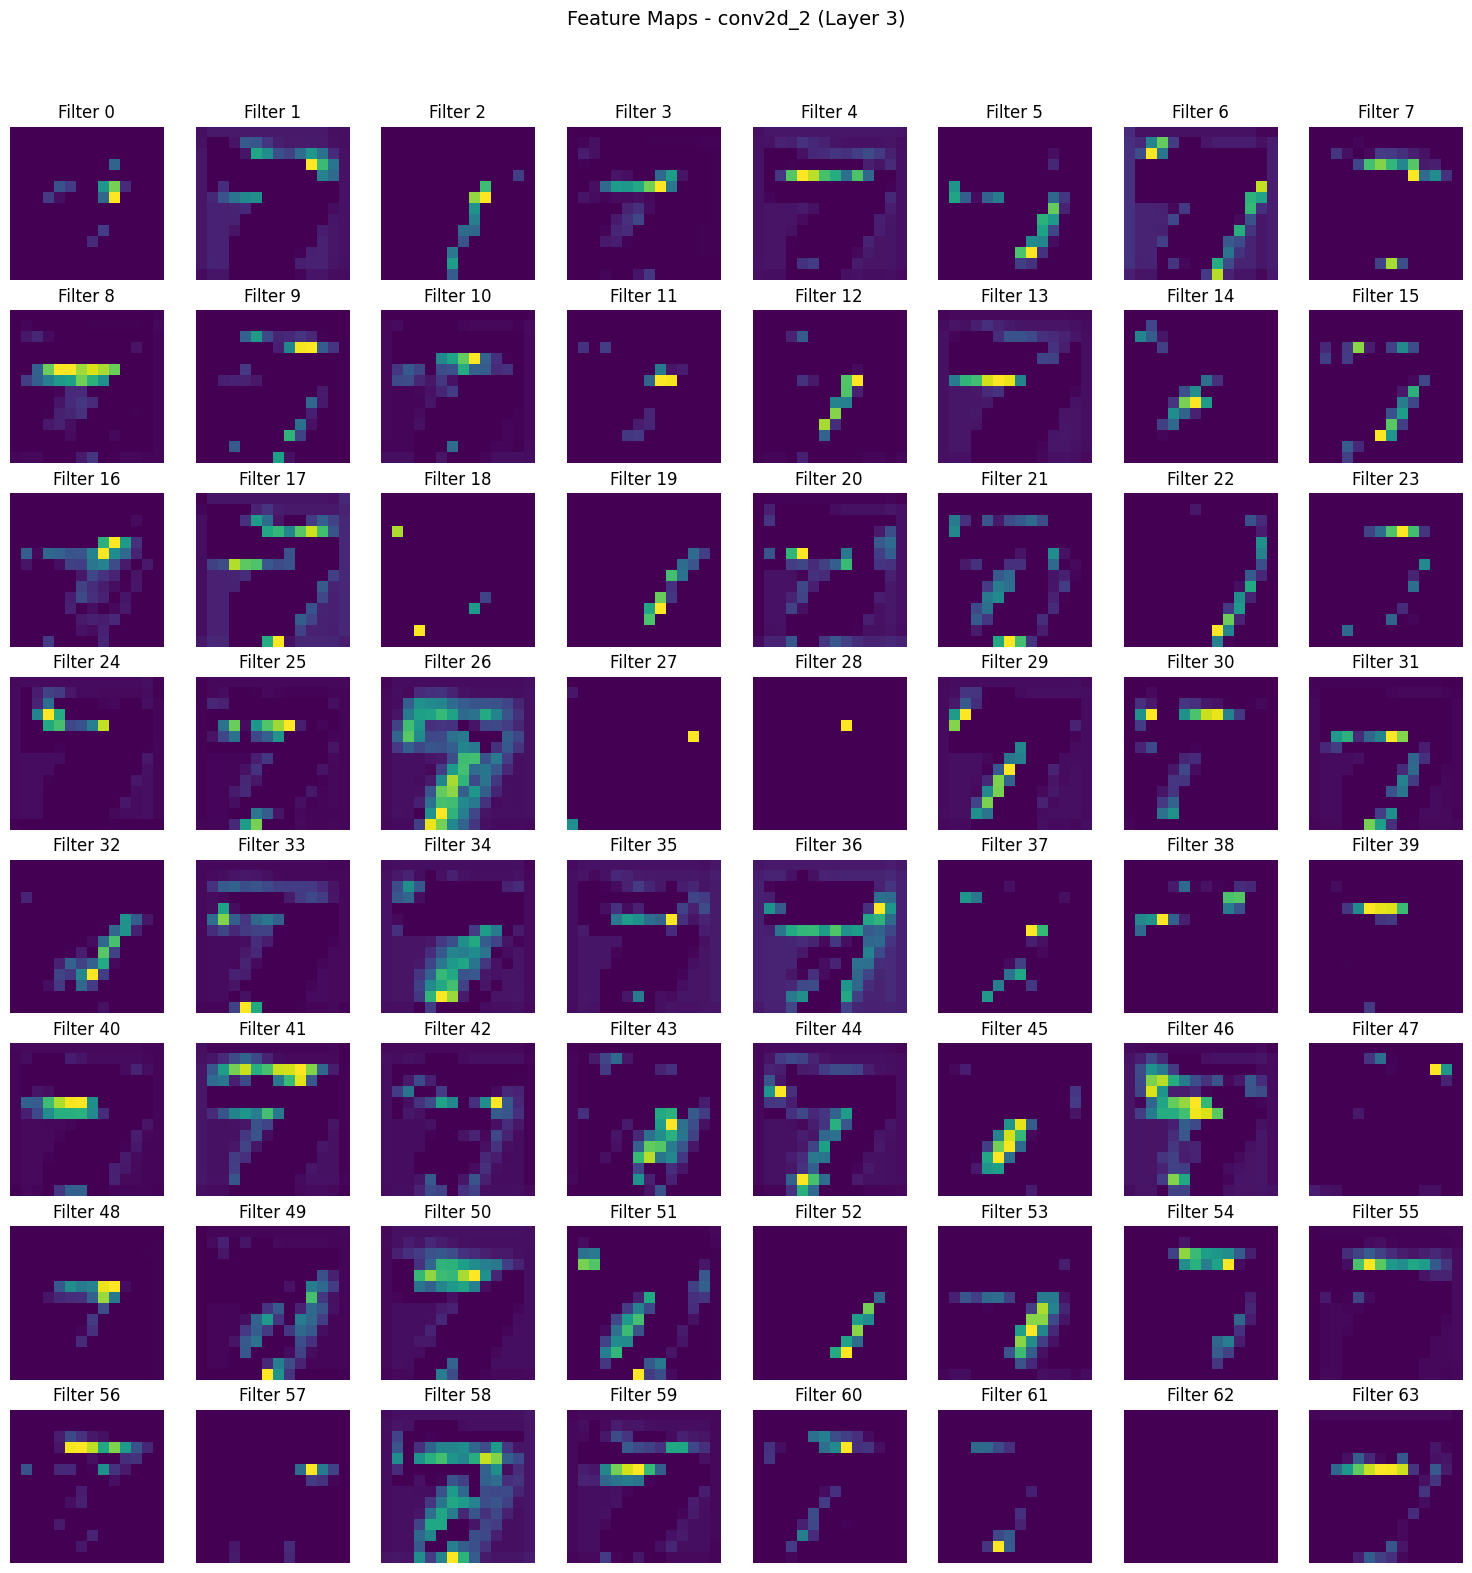

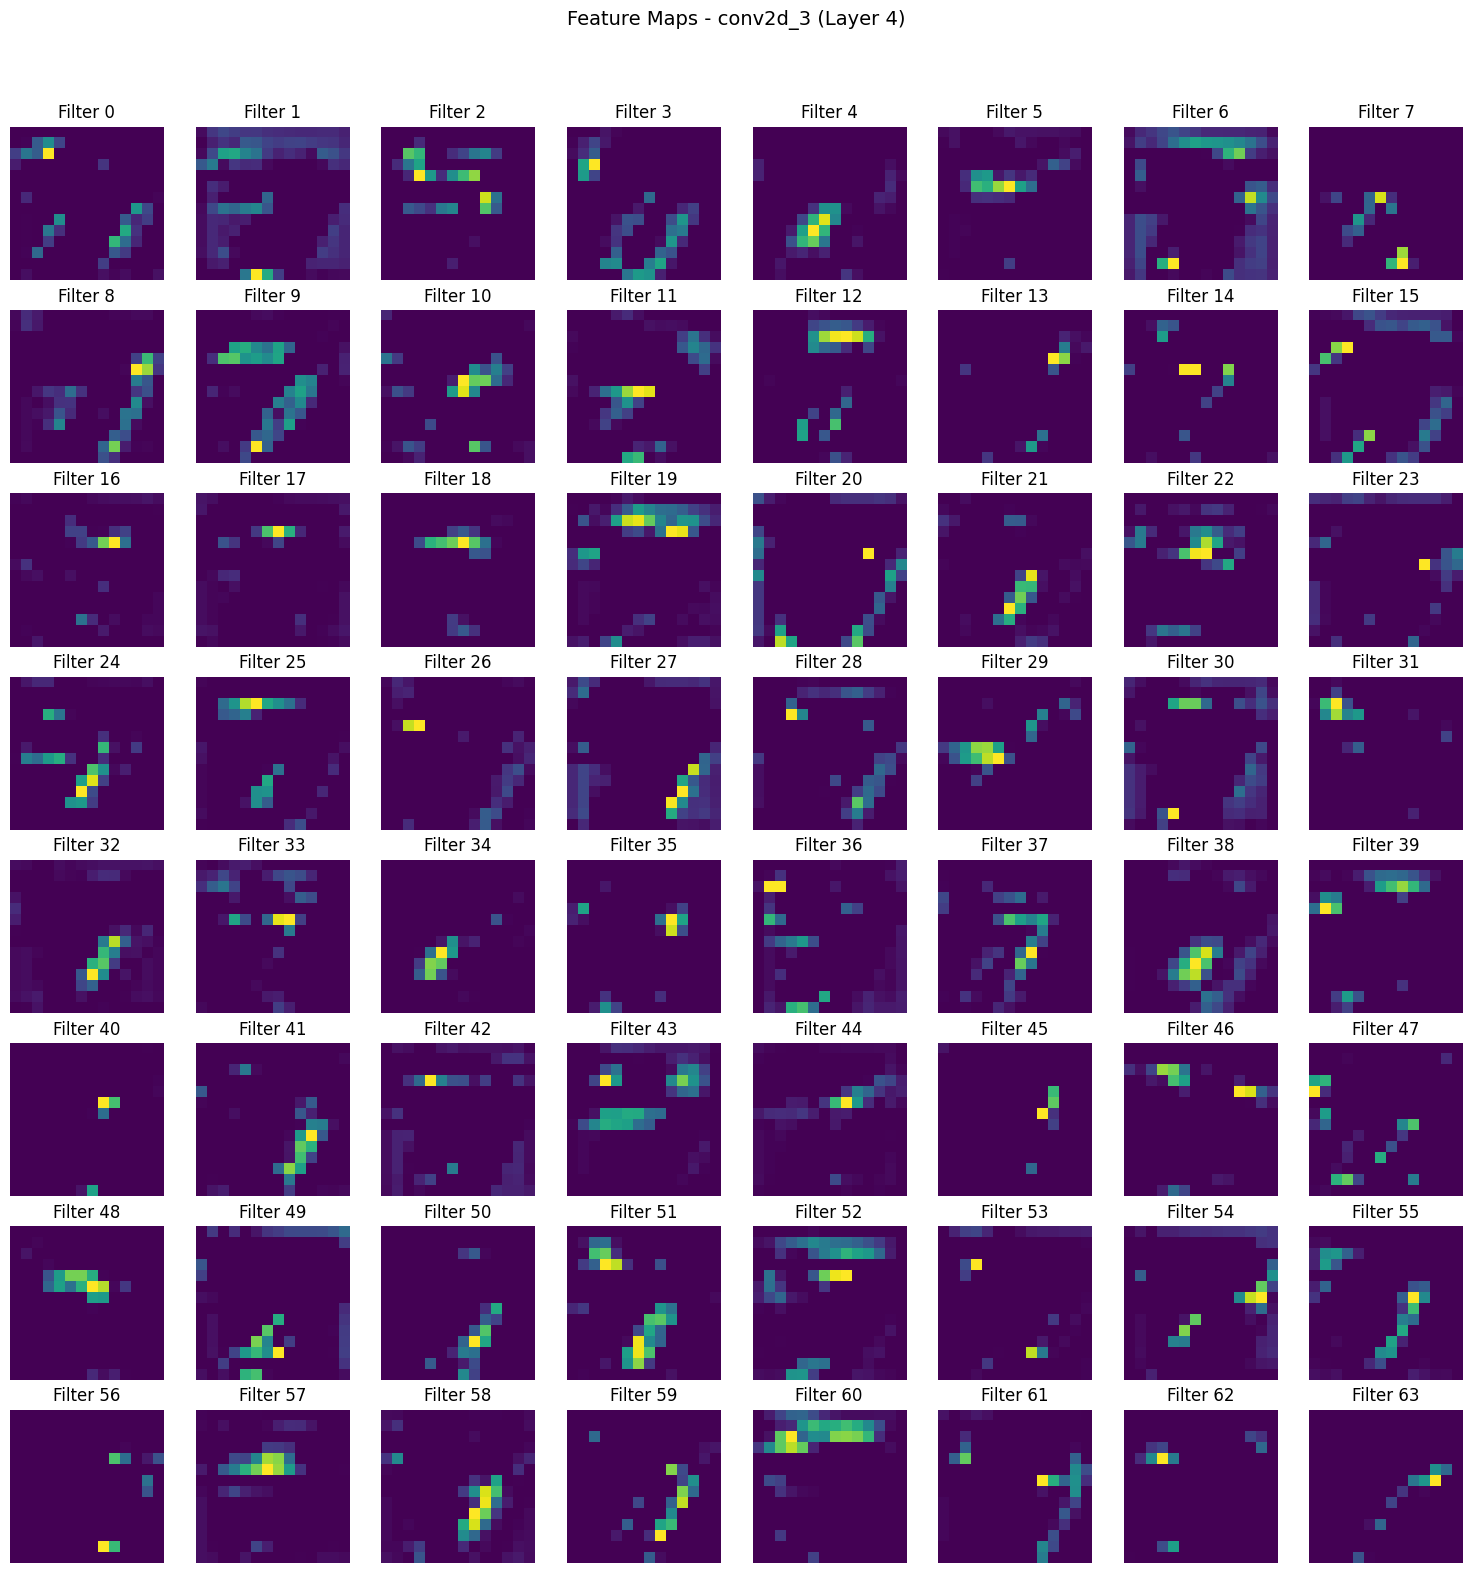

In [17]:
def visualize_feature_maps(model, x_test):
    """Visualize feature maps (activations) for a test image."""
    # Get a test image
    test_img = x_test[0:1]  # Add batch dimension
    
    # Create a model that outputs feature maps from all conv layers
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name.lower()]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    
    # Get activations
    activations = activation_model.predict(test_img)
    
    # Plot the input image
    plt.figure(figsize=(6, 6))
    plt.imshow(test_img[0, :, :, 0], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    plt.savefig('figures/input_image.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot feature maps for each convolutional layer
    for i, layer_activation in enumerate(activations):
        layer_name = [layer.name for layer in model.layers if 'conv' in layer.name.lower()][i]
        n_features = layer_activation.shape[-1]  # Number of features in the feature map
        
        # Calculate grid size
        size = layer_activation.shape[1]
        n_cols = min(8, n_features)
        n_rows = int(np.ceil(n_features / n_cols))
        
        # Create figure
        fig = plt.figure(figsize=(15, n_rows * 2))
        fig.suptitle(f'Feature Maps - {layer_name} (Layer {i+1})', fontsize=14)
        
        # Plot each feature map
        for j in range(n_features):
            plt.subplot(n_rows, n_cols, j + 1)
            plt.imshow(layer_activation[0, :, :, j], cmap='viridis')
            plt.title(f'Filter {j}')
            plt.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f'figures/feature_maps_layer_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Visualize feature maps
visualize_feature_maps(model, x_test)

# 8. Model Improvement Strategies

There are several strategies we can use to potentially improve our CNN model for MNIST digit recognition:

1. **Deeper Architecture**: Add more convolutional layers to capture more complex features.
2. **Learning Rate Scheduling**: Implement a learning rate schedule to fine-tune the training process.
3. **More Data Augmentation**: Add additional augmentation techniques to increase the diversity of training data.
4. **Ensemble Methods**: Combine multiple models to improve overall performance.
5. **Transfer Learning**: Use pre-trained models and fine-tune them for our task.

Let's implement a slightly more complex model architecture and compare its performance with our original model.

In [18]:
def create_deeper_cnn():
    """Create a deeper CNN model for MNIST classification."""
    model = models.Sequential([
        # Input layer (28x28x1)
        layers.Input(shape=(28, 28, 1)),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    return model

# Create and compile the deeper model
deeper_model = create_deeper_cnn()
deeper_model = compile_model(deeper_model)
deeper_model.summary()

# Train the deeper model (optional - uncomment to run)
# deeper_history = train_model(deeper_model, x_train, y_train, x_val, y_val, callbacks)

# Evaluate the deeper model (optional - uncomment to run)
# deeper_test_loss, deeper_test_accuracy = evaluate_model(deeper_model, x_test, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)       

# 9. Conclusion

In this notebook, we've demonstrated the implementation of a Convolutional Neural Network (CNN) for digit recognition using the MNIST dataset. We've covered the entire machine learning pipeline:

1. **Data Preparation**: Loading, preprocessing, and visualizing the MNIST dataset
2. **Model Architecture**: Designing and implementing a CNN architecture for digit recognition
3. **Model Training**: Training the model with appropriate callbacks and monitoring
4. **Model Evaluation**: Evaluating the model's performance on test data
5. **Visualization**: Visualizing feature maps to understand what the CNN learns
6. **Improvement Strategies**: Discussing ways to improve model performance

Our CNN model achieved high accuracy on the MNIST dataset, demonstrating the effectiveness of convolutional neural networks for image classification tasks. The visualizations provided insights into how the model processes the input images and what features it extracts at different levels.

# 10. Further Reading

Here are some resources for further learning about CNNs and digit recognition:

1. **Books**:
   - "Deep Learning" by Ian Goodfellow, Yoshua Bengio, and Aaron Courville
   - "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron

2. **Online Courses**:
   - Coursera's Deep Learning Specialization by Andrew Ng
   - Fast.ai's Practical Deep Learning for Coders

3. **Research Papers**:
   - "Gradient-Based Learning Applied to Document Recognition" by Yann LeCun et al.
   - "ImageNet Classification with Deep Convolutional Neural Networks" by Alex Krizhevsky et al.

4. **Websites and Blogs**:
   - TensorFlow and Keras official documentation
   - Distill.pub for visualizations and explanations of deep learning concepts
   - PyImageSearch for practical computer vision tutorials